In [34]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [35]:
DATA_PATH = './data/splitlabel/'
IMAGE_PATH = './data/467case_cut-20190916T015832Z-001/'
os.listdir(DATA_PATH)

['test_문-격자무늬 창.xlsx',
 'test_위치-집-아래.xlsx',
 'test_위치-집-정중앙.xlsx',
 'test_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'test_지붕-그물무늬 음영.xlsx',
 'test_창문-격자무늬.xlsx',
 'test_창문-많다.xlsx',
 'test_창문-창문을 가린 커튼.xlsx',
 'train_문-격자무늬 창.xlsx',
 'train_위치-집-아래.xlsx',
 'train_위치-집-정중앙.xlsx',
 'train_지면선-벽 밑면 있지만 지면 없음.xlsx',
 'train_지붕-그물무늬 음영.xlsx',
 'train_창문-격자무늬.xlsx',
 'train_창문-많다.xlsx',
 'train_창문-창문을 가린 커튼.xlsx',
 '문-격자무늬 창.xlsx',
 '위치-집-아래.xlsx',
 '위치-집-정중앙.xlsx',
 '지면선-벽 밑면 있지만 지면 없음.xlsx',
 '지붕-그물무늬 음영.xlsx',
 '창문-격자무늬.xlsx',
 '창문-많다.xlsx',
 '창문-창문을 가린 커튼.xlsx']

In [36]:
house = ['문-격자무늬 창',
 '위치-집-아래',
 '위치-집-정중앙',
 '지면선-벽 밑면 있지만 지면 없음',
 '지붕-그물무늬 음영',
 '창문-격자무늬',
 '창문-많다',
 '창문-창문을 가린 커튼']

In [37]:
TRAIN_CROP_PATH = './train_crop'
TRAIN_IMG_PATH = os.path.join(IMAGE_PATH,'house')


df_train = []
df_test = []
for excel_name in house:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH,'train_' + excel_name + '.xlsx')))
    df_train[house.index(excel_name)]['data'] = df_train[house.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH,'test_' + excel_name + '.xlsx')))
    df_test[house.index(excel_name)]['data'] = df_test[house.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    
    

In [38]:
for i in range(len(house)):
    print(df_train[i].head(5))
    print(df_test[i].head(5))

   Unnamed: 0        data  문-격자무늬 창
0         144  0270_H.jpg         0
1          70  0117_H.jpg         0
2         138  0261_H.jpg         0
3         131  0243_H.jpg         0
4         214  0415_H.jpg         0
   Unnamed: 0        data  문-격자무늬 창
0         170  0319_H.jpg         0
1          51  0089_H.jpg         0
2          36  0062_H.jpg         0
3           8  0012_H.jpg         0
4         132  0248_H.jpg         0
   Unnamed: 0        data  위치-집-아래
0          79  0132_H.jpg        0
1         188  0360_H.jpg        0
2          25  0043_H.jpg        0
3          53  0091_H.jpg        0
4         169  0318_H.jpg        0
   Unnamed: 0        data  위치-집-아래
0         227  0432_H.jpg        0
1         177  0335_H.jpg        0
2         221  0424_H.jpg        1
3         167  0315_H.jpg        1
4         283  0519_H.jpg        1
   Unnamed: 0        data  위치-집-정중앙
0         165  0311_H.jpg         0
1          25  0043_H.jpg         0
2         245  0463_H.jpg         0
3   

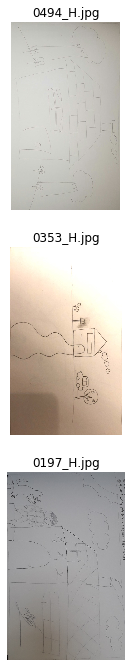

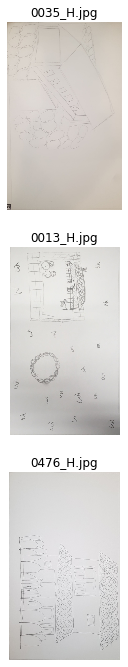

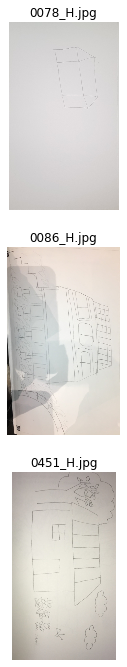

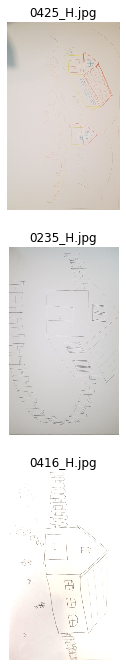

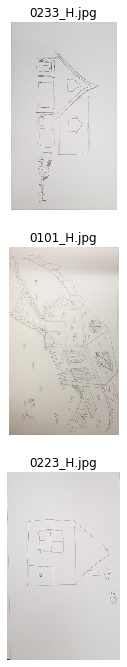

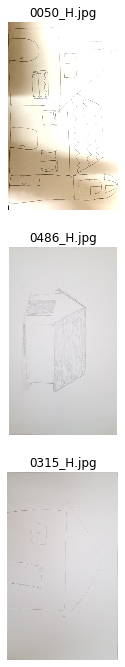

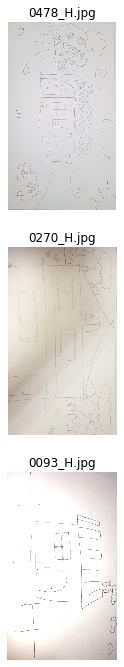

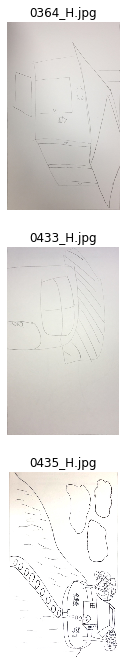

In [39]:
for i in range(len(df_train)):
    tmp_imgs = df_train[i]['data'][100:103]
    plt.figure(figsize=(12,20))

    for num, f_name in enumerate(tmp_imgs):
        img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')

In [40]:
from sklearn.model_selection import train_test_split

X_train = []
X_val = []

for i, data in enumerate(house):

    df_train[i][data] = df_train[i][data].astype('str')
    y = df[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]

    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42, stratify=y)

    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])

    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print("="*20)

문-격자무늬 창
(190, 2)
(48, 2)
(238, 2)
위치-집-아래
(190, 2)
(48, 2)
(238, 2)
위치-집-정중앙
(190, 2)
(48, 2)
(238, 2)
지면선-벽 밑면 있지만 지면 없음
(190, 2)
(48, 2)
(238, 2)
지붕-그물무늬 음영
(190, 2)
(48, 2)
(238, 2)
창문-격자무늬
(190, 2)
(48, 2)
(238, 2)
창문-많다
(190, 2)
(48, 2)
(238, 2)
창문-창문을 가린 커튼
(190, 2)
(48, 2)
(238, 2)


In [41]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [43]:

epochs = 20
batch_size = 32
img_size = (224, 224)
# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(house):
    nb_train_samples.append(len(X_train[i]))
    nb_validation_samples.append(len(X_val[i]))
    nb_test_samples.append(len(df_train[i]))
    
    
    # Make Generator
    train_generator.append(train_datagen.flow_from_dataframe(
        dataframe=X_train[i], 
        directory=TRAIN_IMG_PATH,
        x_col = 'data',
        y_col = house[i],
        target_size = img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        seed=42
    ))

    validation_generator.append(val_datagen.flow_from_dataframe(
        dataframe=X_val[i], 
        directory=TRAIN_IMG_PATH,
        x_col='data',
        y_col=house[i],
        target_size=img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    ))

    test_generator.append(test_datagen.flow_from_dataframe(
        dataframe=df_test[i],
        directory=TRAIN_IMG_PATH,
        x_col='data',
        y_col=None,
        target_size= img_size,
        color_mode='rgb',
        class_mode=None,
        batch_size=batch_size,
        shuffle=False
    ))

Found 190 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="data". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 59 validated image filenames.
Found 190 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 59 validated image filenames.
Found 190 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 59 validated image filenames.
Found 189 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 60 validated image filenames.
Found 190 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 59 validated image filenames.
Found 190 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 59 validated image filenames.
Found 190 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.
Found 59 validated image filenames.
Found 190 validated image filename

In [44]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [50]:
def MakeMobileModel():
    mobileNetModel = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
model = MakeMobileModel()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [51]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')



In [52]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else : 
        return num_samples // batch_size

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

history = []

for i, ename in enumerate(house):
    model = MakeMobileModel()
    filepath = ename + "_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5"
    
    ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

    callbackList = [ckpt]

    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = get_steps(nb_train_samples[i], batch_size),
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

Epoch 1/20
5/6 [========================>.....] - ETA: 1:28 - loss: 1.0690 - acc: 0.343 - ETA: 1:00 - loss: 0.7233 - acc: 0.625 - ETA: 41s - loss: 0.5442 - acc: 0.723 - ETA: 26s - loss: 0.4325 - acc: 0.77 - ETA: 13s - loss: 0.3739 - acc: 0.8165
Epoch 00001: val_acc improved from -inf to 0.02083, saving model to 문-격자무늬 창_mobile_model_0.02_12.0364.h5
6/6 [==============================] - 83s 14s/step - loss: 0.3558 - acc: 0.8316 - val_loss: 12.0364 - val_acc: 0.0208
Epoch 2/20
5/6 [========================>.....] - ETA: 1:03 - loss: 0.0738 - acc: 0.968 - ETA: 51s - loss: 0.0492 - acc: 0.984 - ETA: 37s - loss: 0.0775 - acc: 0.96 - ETA: 24s - loss: 0.0629 - acc: 0.97 - ETA: 12s - loss: 0.0641 - acc: 0.9747
Epoch 00002: val_acc improved from 0.02083 to 0.97917, saving model to 문-격자무늬 창_mobile_model_0.98_0.1769.h5
6/6 [==============================] - 75s 13s/step - loss: 0.0663 - acc: 0.9737 - val_loss: 0.1769 - val_acc: 0.9792
Epoch 3/20
5/6 [========================>.....] - ETA: 1:01 -

Epoch 20/20
5/6 [========================>.....] - ETA: 1:06 - loss: 1.7173e-05 - acc: 1.000 - ETA: 53s - loss: 2.5613e-05 - acc: 1.000 - ETA: 39s - loss: 1.9581e-05 - acc: 1.00 - ETA: 26s - loss: 1.9190e-05 - acc: 1.00 - ETA: 12s - loss: 3.3978e-05 - acc: 1.0000
Epoch 00020: val_acc did not improve from 0.97917
6/6 [==============================] - 82s 14s/step - loss: 3.2731e-05 - acc: 1.0000 - val_loss: 0.1424 - val_acc: 0.9792


C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:38 - loss: 0.7330 - acc: 0.718 - ETA: 1:06 - loss: 0.8530 - acc: 0.640 - ETA: 45s - loss: 0.8160 - acc: 0.656 - ETA: 28s - loss: 0.8135 - acc: 0.64 - ETA: 13s - loss: 0.8212 - acc: 0.6438
Epoch 00001: val_acc improved from -inf to 0.29167, saving model to 위치-집-아래_mobile_model_0.29_2.1353.h5
6/6 [==============================] - 88s 15s/step - loss: 0.8361 - acc: 0.6684 - val_loss: 2.1353 - val_acc: 0.2917
Epoch 2/20
5/6 [========================>.....] - ETA: 1:01 - loss: 0.0313 - acc: 1.000 - ETA: 51s - loss: 0.0343 - acc: 1.000 - ETA: 39s - loss: 0.1776 - acc: 0.95 - ETA: 26s - loss: 0.1493 - acc: 0.96 - ETA: 13s - loss: 0.1356 - acc: 0.9620
Epoch 00002: val_acc improved from 0.29167 to 0.83333, saving model to 위치-집-아래_mobile_model_0.83_1.7639.h5
6/6 [==============================] - 82s 14s/step - loss: 0.1396 - acc: 0.9579 - val_loss: 1.7639 - val_acc: 0.8333
Epoch 3/20
5/6 [========================>.....] - ETA: 59s - loss

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:36 - loss: 1.0008 - acc: 0.468 - ETA: 1:04 - loss: 0.9201 - acc: 0.593 - ETA: 44s - loss: 0.7220 - acc: 0.697 - ETA: 28s - loss: 0.6802 - acc: 0.75 - ETA: 13s - loss: 0.6215 - acc: 0.7785
Epoch 00001: val_acc improved from -inf to 0.08333, saving model to 위치-집-정중앙_mobile_model_0.08_1.9945.h5
6/6 [==============================] - 87s 15s/step - loss: 0.6287 - acc: 0.7947 - val_loss: 1.9945 - val_acc: 0.0833
Epoch 2/20
5/6 [========================>.....] - ETA: 1:07 - loss: 0.0256 - acc: 1.000 - ETA: 49s - loss: 0.0558 - acc: 0.983 - ETA: 38s - loss: 0.0805 - acc: 0.96 - ETA: 25s - loss: 0.0970 - acc: 0.96 - ETA: 12s - loss: 0.0899 - acc: 0.9684
Epoch 00002: val_acc improved from 0.08333 to 0.91667, saving model to 위치-집-정중앙_mobile_model_0.92_0.7068.h5
6/6 [==============================] - 81s 13s/step - loss: 0.0846 - acc: 0.9684 - val_loss: 0.7068 - val_acc: 0.9167
Epoch 3/20
5/6 [========================>.....] - ETA: 1:08 - l

Epoch 20/20
5/6 [========================>.....] - ETA: 1:06 - loss: 4.7414e-05 - acc: 1.000 - ETA: 51s - loss: 4.6073e-05 - acc: 1.000 - ETA: 39s - loss: 3.8895e-05 - acc: 1.00 - ETA: 26s - loss: 3.5990e-05 - acc: 1.00 - ETA: 13s - loss: 3.2176e-05 - acc: 1.0000
Epoch 00020: val_acc did not improve from 0.91667
6/6 [==============================] - 81s 14s/step - loss: 5.9373e-05 - acc: 1.0000 - val_loss: 0.8081 - val_acc: 0.8958


C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:37 - loss: 0.8543 - acc: 0.517 - ETA: 1:05 - loss: 0.8267 - acc: 0.524 - ETA: 46s - loss: 1.0713 - acc: 0.548 - ETA: 29s - loss: 1.0314 - acc: 0.56 - ETA: 14s - loss: 1.0801 - acc: 0.5669
Epoch 00001: val_acc improved from -inf to 0.66667, saving model to 지면선-벽 밑면 있지만 지면 없음_mobile_model_0.67_7.2090.h5
6/6 [==============================] - 94s 16s/step - loss: 1.1526 - acc: 0.5661 - val_loss: 7.2090 - val_acc: 0.6667
Epoch 2/20
5/6 [========================>.....] - ETA: 1:09 - loss: 0.0416 - acc: 0.968 - ETA: 54s - loss: 0.1219 - acc: 0.953 - ETA: 40s - loss: 0.2492 - acc: 0.92 - ETA: 26s - loss: 0.3078 - acc: 0.89 - ETA: 13s - loss: 0.2557 - acc: 0.9108
Epoch 00002: val_acc did not improve from 0.66667
6/6 [==============================] - 81s 13s/step - loss: 0.2283 - acc: 0.9153 - val_loss: 3.5143 - val_acc: 0.6667
Epoch 3/20
5/6 [========================>.....] - ETA: 1:08 - loss: 0.1036 - acc: 0.968 - ETA: 53s - loss: 0.10

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:36 - loss: 0.5851 - acc: 0.656 - ETA: 1:02 - loss: 0.7018 - acc: 0.687 - ETA: 43s - loss: 0.6520 - acc: 0.718 - ETA: 27s - loss: 0.6775 - acc: 0.72 - ETA: 13s - loss: 0.7023 - acc: 0.7152
Epoch 00001: val_acc improved from -inf to 0.54167, saving model to 지붕-그물무늬 음영_mobile_model_0.54_1.1077.h5
6/6 [==============================] - 87s 15s/step - loss: 0.6995 - acc: 0.7263 - val_loss: 1.1077 - val_acc: 0.5417
Epoch 2/20
5/6 [========================>.....] - ETA: 1:02 - loss: 0.2679 - acc: 0.937 - ETA: 49s - loss: 0.3144 - acc: 0.890 - ETA: 36s - loss: 0.2442 - acc: 0.90 - ETA: 24s - loss: 0.2652 - acc: 0.89 - ETA: 12s - loss: 0.2559 - acc: 0.9051
Epoch 00002: val_acc improved from 0.54167 to 0.75000, saving model to 지붕-그물무늬 음영_mobile_model_0.75_2.2662.h5
6/6 [==============================] - 76s 13s/step - loss: 0.2367 - acc: 0.9053 - val_loss: 2.2662 - val_acc: 0.7500
Epoch 3/20
5/6 [========================>.....] - ETA: 1:02

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:40 - loss: 0.9396 - acc: 0.500 - ETA: 1:02 - loss: 1.0688 - acc: 0.548 - ETA: 45s - loss: 1.0972 - acc: 0.585 - ETA: 30s - loss: 1.2540 - acc: 0.58 - ETA: 14s - loss: 1.1256 - acc: 0.6139
Epoch 00001: val_acc improved from -inf to 0.66667, saving model to 창문-격자무늬_mobile_model_0.67_3.7010.h5
6/6 [==============================] - 96s 16s/step - loss: 1.2445 - acc: 0.6053 - val_loss: 3.7010 - val_acc: 0.6667
Epoch 2/20
5/6 [========================>.....] - ETA: 1:01 - loss: 0.3134 - acc: 0.843 - ETA: 50s - loss: 0.2979 - acc: 0.875 - ETA: 37s - loss: 0.2444 - acc: 0.89 - ETA: 24s - loss: 0.3060 - acc: 0.87 - ETA: 12s - loss: 0.4360 - acc: 0.8481
Epoch 00002: val_acc did not improve from 0.66667
6/6 [==============================] - 76s 13s/step - loss: 0.4729 - acc: 0.8421 - val_loss: 4.2052 - val_acc: 0.3333
Epoch 3/20
5/6 [========================>.....] - ETA: 1:01 - loss: 0.1194 - acc: 0.937 - ETA: 49s - loss: 0.0722 - acc: 0

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:40 - loss: 1.2755 - acc: 0.437 - ETA: 1:04 - loss: 1.1305 - acc: 0.484 - ETA: 44s - loss: 1.1420 - acc: 0.531 - ETA: 27s - loss: 1.1108 - acc: 0.56 - ETA: 13s - loss: 1.1365 - acc: 0.5886
Epoch 00001: val_acc improved from -inf to 0.75000, saving model to 창문-많다_mobile_model_0.75_1.6799.h5
6/6 [==============================] - 90s 15s/step - loss: 1.0504 - acc: 0.6158 - val_loss: 1.6799 - val_acc: 0.7500
Epoch 2/20
5/6 [========================>.....] - ETA: 56s - loss: 0.1249 - acc: 0.96 - ETA: 46s - loss: 0.0971 - acc: 0.96 - ETA: 34s - loss: 0.1410 - acc: 0.95 - ETA: 23s - loss: 0.2208 - acc: 0.94 - ETA: 11s - loss: 0.3124 - acc: 0.9177
Epoch 00002: val_acc did not improve from 0.75000
6/6 [==============================] - 73s 12s/step - loss: 0.3574 - acc: 0.9053 - val_loss: 4.1598 - val_acc: 0.7500
Epoch 3/20
5/6 [========================>.....] - ETA: 1:00 - loss: 0.0643 - acc: 0.968 - ETA: 45s - loss: 0.0740 - acc: 0.967 

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
5/6 [========================>.....] - ETA: 1:41 - loss: 1.2411 - acc: 0.312 - ETA: 1:04 - loss: 0.9484 - acc: 0.468 - ETA: 44s - loss: 0.8477 - acc: 0.562 - ETA: 27s - loss: 0.7524 - acc: 0.63 - ETA: 13s - loss: 0.8093 - acc: 0.6709
Epoch 00001: val_acc improved from -inf to 0.91667, saving model to 창문-창문을 가린 커튼_mobile_model_0.92_1.1340.h5
6/6 [==============================] - 90s 15s/step - loss: 0.7375 - acc: 0.7053 - val_loss: 1.1340 - val_acc: 0.9167
Epoch 2/20
5/6 [========================>.....] - ETA: 59s - loss: 0.0788 - acc: 0.96 - ETA: 47s - loss: 0.0962 - acc: 0.95 - ETA: 35s - loss: 0.1821 - acc: 0.93 - ETA: 23s - loss: 0.1600 - acc: 0.94 - ETA: 11s - loss: 0.1294 - acc: 0.9557
Epoch 00002: val_acc did not improve from 0.91667
6/6 [==============================] - 73s 12s/step - loss: 0.1673 - acc: 0.9526 - val_loss: 2.2987 - val_acc: 0.9167
Epoch 3/20
5/6 [========================>.....] - ETA: 1:01 - loss: 0.0654 - acc: 0.937 - ETA: 46s - loss: 0.1045 - acc:

문-격자무늬 창


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45740 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52285 missing from c

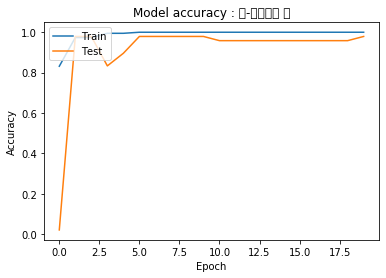

위치-집-아래


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50948 missing from c

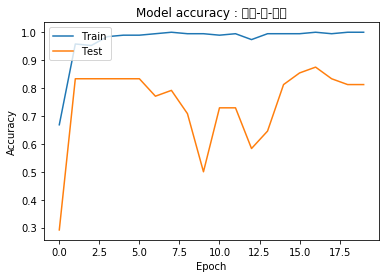

위치-집-정중앙


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50521 missing from curre

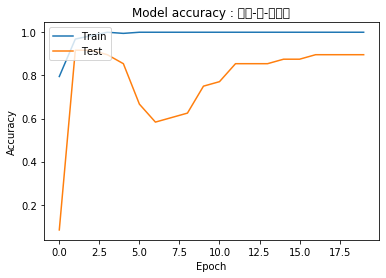

지면선-벽 밑면 있지만 지면 없음


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47732 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48317 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51080 missing from c

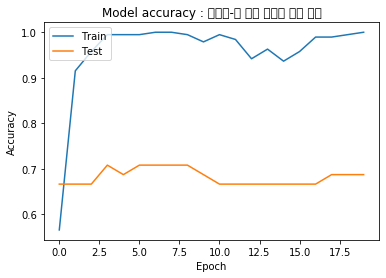

지붕-그물무늬 음영


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48533 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 44536 missing from cur

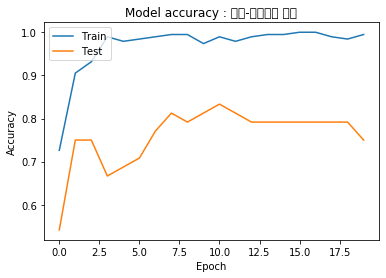

창문-격자무늬


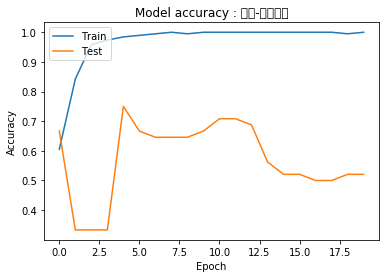

창문-많다


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47566 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47566 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0, flags=flags)


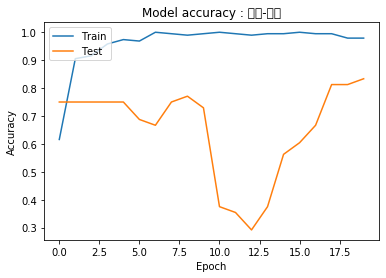

창문-창문을 가린 커튼


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51012 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51012 missing from c

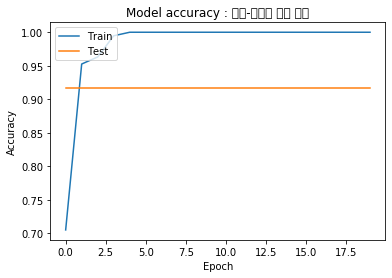

In [54]:
for i, data in enumerate(house):
    print(data)
    plt.plot(history[i].history['acc'])
    plt.plot(history[i].history['val_acc'])
    plt.title('Model accuracy : ' + data)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

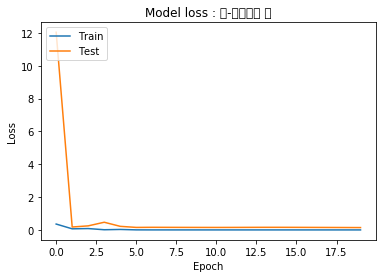

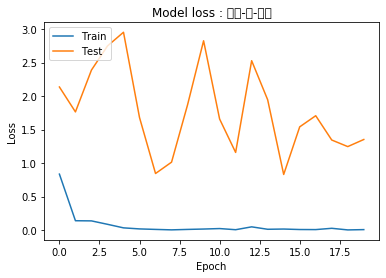

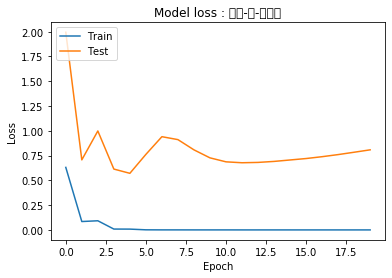

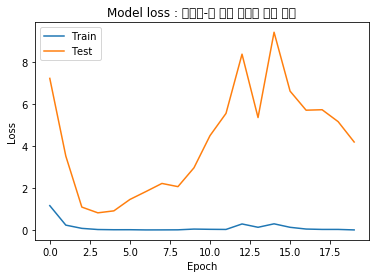

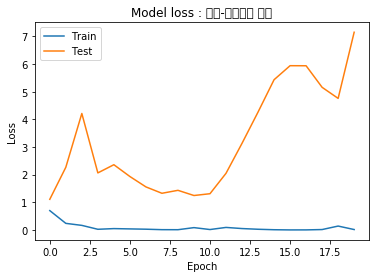

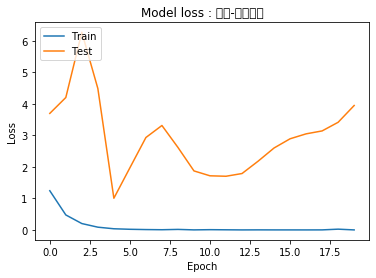

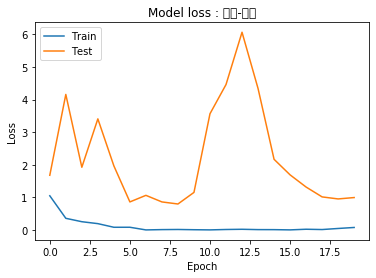

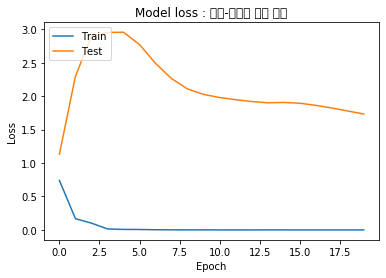

In [55]:
# Plot training & validation loss values
for i, data in enumerate(house):
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('Model loss : ' + data)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [ ]:
model_list = sorted([i for i in os.listdir() if "my_" in i])
model_list

In [ ]:
model.load_weights(model_list[-1])

In [ ]:
test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

In [ ]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()